# Forecasting Mid-Pandemic Boston Bikesharing Demand 
### Ian Klasky
#### Aug 7, 2020

This notebook shows how forecasts of daily bikeshare demand in Boston change before and after the COVID-related state of emergency was declared in Massachussetts.

The notebook is structured as follows:

* [Preprocessing](#Preprocessing)
    * [Importing Basic Packages & Data](#Importing)
    * [Formatting & Cleaning Data](#Formatting)
* [Modeling](#Modeling)
    * [Model Selection](#Selection)
    * [Forecasting](#Forecasting)
        * [Forecast 1](#fc1)
        * [Forecast 2](#fc2)
        * [Forecast 3](#fc3)
* [Conclusions & Final Forecast](#Conclusions)

# Preprocessing<a name="Preprocessing"></a>

## Importing Basic Packages & Data<a name="Importing"></a>

In [1]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Greater Boston's Bluebikes bikesharing program publishes its trip data once a month to a csv on its [website](https://s3.amazonaws.com/hubway-data/index.html), making it easy to collect for this project.

I downloaded the available data from January 2017, all the way up to June 2020. We can see the first 3 entries from the dataset in a pandas dataframe below.

In [2]:
df = pd.read_csv('data/blue_bikes_trip_data/201701-hubway-tripdata.csv', index_col=1, parse_dates=True)

path = './data/blue_bikes_trip_data/'
for file in sorted(os.listdir(path))[2:]:
    df_new = pd.read_csv(path+file, index_col=1, parse_dates=True)
    frames = [df,df_new]
    df = pd.concat(frames)

df.head(3)

,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,postal code
starttime,,,,,,,,,,,,,,,
2017-01-01 00:06:58,350,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,139,Dana Park,42.361780,-71.108100,644,Subscriber,1988,1.0,NaN
2017-01-01 00:13:16,891,2017-01-01 00:28:07,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,10,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,230,Subscriber,1983,1.0,NaN
2017-01-01 00:16:17,1672,2017-01-01 00:44:10,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,9,Agganis Arena - 925 Comm Ave.,42.351246,-71.115639,980,Customer,\N,0.0,NaN


## Formatting & Cleaning Data<a name="Formatting"></a>

This dataframe contains information on each trip logged by the system in chronological order. However, for this analysis we're interested in the total number of trips the system logged each day. This requires us to group the rides by calendar day and sum the total number of trips in each daily group. These steps yield the dataframe below, which consists of the number of rides for each recorded day (zero-indexed).

In [3]:
daily_data = df.groupby([pd.Grouper(freq='D')]).count().reset_index().iloc[:, : 2]
daily_data.columns = ['date','trips']
daily_data

,date,trips
0,2017-01-01,481
1,2017-01-02,802
2,2017-01-03,651
3,2017-01-04,1534
4,2017-01-05,1330
...,...,...
1272,2020-06-26,8493
1273,2020-06-27,7228
1274,2020-06-28,4806
1275,2020-06-29,4634


Many time series models require data to be presented in uniform intervals of time. There are two days in our dataframe that have no recorded trip data. Background research revealed that there were major storms (nor’ easters) occurring in the area on those days and in at least one case, the Bluebikes service was shut down for the day. I imputed 0’s for both days to make the data uniformly spaced in time.

In [4]:
if 'date' in daily_data.columns:
    daily_data=daily_data.set_index('date')
    daily_data.index = daily_data.index.date

    daily_data.loc[dt.datetime.strptime('2018-03-13', '%Y-%m-%d').date()] = [0]
    daily_data.loc[dt.datetime.strptime('2019-01-20', '%Y-%m-%d').date()] = [0]
    
daily_data.sort_index(inplace=True)
daily_data.index.rename('date',inplace=True)
daily_data.reset_index(inplace=True)

We can see the time series of the daily blue bike rides in greater Boston from 2017 to 2020 below.

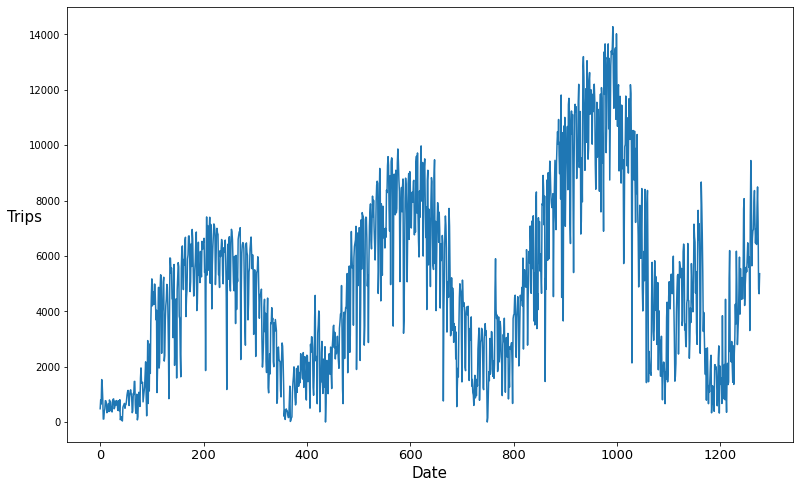

In [5]:
plt.figure(figsize=(13, 8))
plt.plot(daily_data.trips)
plt.ylabel('Trips',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.show()

We can see an annual seasonal trend for about the first 3 years of this data. However, around the time the statewide COVID-induced state of emergency was declared on March 11th we see a massive drop-off in daily rides.

Now that we see a major change in consumer behavior around the time of the state of emergency, we can build our models to see predicted demand for 2020 as well as what the demand predicted after being given the data through March of 2020 (and beyond).

# Modeling<a name="Modeling"></a>

## Model Selection<a name="Selection"></a>

We now need to select which models we will use to forecast demand. One classic and widely used time series model is the ARIMA model. However, after some background research into its applicability to this specific problem, I found that it was not suitable for two reasons.

The first reason is that ARIMA models are typically too computationally intensive to run for time series with a seasonal order of more than around 200. Since our data is daily and we have annual seasonality, our time series has a seasonal order of 365. We can also see evidence of this seasonal order in the autocorrelation plot below. In the plot, we see higher correlation between points in our time series that are 365 days away from them.

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Figure(432x288)


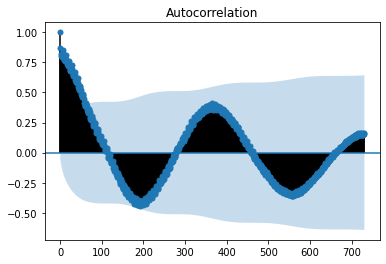

In [7]:
print(plot_acf(daily_data.trips, lags=730))

The second problem an ARIMA model would have in this situation is that there are multiple seasonalities in our data.

We saw evidence of annual seasonality from the autocorrelation plot above, and in a ‘zoomed-in’ version of the same autocorrelation plot below we can see local-maxima in the correlations at every 7 data points. This suggests a weekly seasonality in our time series.

Figure(432x288)


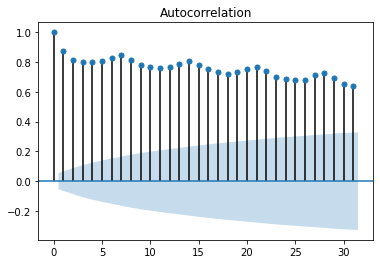

In [8]:
print(plot_acf(daily_data.trips, lags=31))

While there are additions one could make to an ARIMA model that could possibly accommodate our data, Rob J. Hyndman - [author](https://robjhyndman.com/software/) of many time series packages for R, [suggests](https://robjhyndman.com/hyndsight/longseasonality/) using a Fourier series-based model for time series with long and/or multiple seasonalities.

Another model that shows promise in forecasting complex time series is Prophet. Prophet was developed by Facebook’s research division and released in 2017. Prophet is a more complicated model that detects trends, seasonalities, and “changepoints” in the data. "Changepoints" are times in the series when the model detects the underlying system has fundamentally changed. It uses multiple techniques including Fourier series and regression to achieve its forecasts.

I'll use the simpler Fast Fourier transform (FFT) model as a baseline with which to compare the shiny new Prophet model in forecasting daily demand for the Bluebikes.

## Forecasting<a name="Forecasting"></a>

I’ll be using the [Darts](https://medium.com/unit8-machine-learning-publication/darts-time-series-made-easy-in-python-5ac2947a8878) package to simplify the (formerly) tedious tasks required to properly format time series data to be run by various models.

In [9]:
from darts import TimeSeries
from darts.models import FFT, Prophet

### Forecast 1<a name="fc1"></a>

For our first forecast I’ll feed the models data from January 1st 2017 to December 31st 2019, and have them predict daily demand for the first half of 2020. The results are visualized in **Cell 15**.

In [10]:
series1 = TimeSeries.from_dataframe(daily_data, 'date', 'trips')
train1, val1 = series1.split_before(pd.Timestamp('20200101'))

In [11]:
import time

In [12]:
start_time = time.time()

model_FFT1 = FFT()
model_FFT1.fit(train1)
prediction_FFT1 = model_FFT1.predict(len(val1))

model_Prophet1 = Prophet(daily_seasonality = True)
model_Prophet1.fit(train1)
prediction_Prophet1 = model_Prophet1.predict(len(val1))

print("--- %s seconds ---" % (time.time() - start_time))

--- 4.631752967834473 seconds ---


In [13]:
from darts.metrics import mape
from darts.metrics import ope

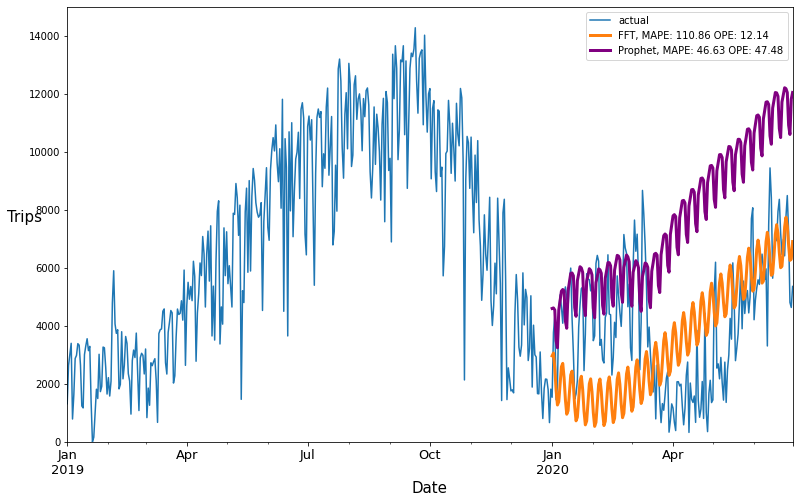

In [14]:
plt.figure(figsize=(13, 8))
series1.plot(label='actual')
prediction_FFT1.plot(label='FFT, MAPE: '+str(round(mape(prediction_FFT1, series1),2))+' OPE: '+str(round(ope(prediction_FFT1, series1),2)),lw=3)
prediction_Prophet1.plot(label='Prophet, MAPE: '+str(round(mape(prediction_Prophet1, series1),2))+' OPE: '+str(round(ope(prediction_Prophet1, series1),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2019-01-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,15000])
plt.ylabel('Trips',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend()
plt.show()

I suspected that the both models might give somewhat reasonable forecasts up until the state of emergency was released, but had no real expectation for accuracy afterwards. We see that FFT majorly underestimated demand pre-state of emergency. While Prophet seemed to be tracking demand pretty well until the state of emergency, it’s way off afterwards.

It's also worth noting that the models took very little time to train and produce forecasts.

### Forecast 2<a name="fc2"></a>

It doesn’t seem terribly useful to judge the models on their ability to predict a pandemic so I’ll now examine their performance up until the state of emergency was announced. The results are visaized in **Cell 18**.

The metrics I’ll use to evaluate the models in this analysis are the mean average percentage error (MAPE), and the  overall percent error (OPE). The first averages how far off the forecasts were from the true values at each recorded point in time, and the second calculates the difference between the sums of all forecasted values and all true values.

In [15]:
series2 = TimeSeries.from_dataframe(daily_data[daily_data['date'] < dt.datetime.strptime('2020-03-11', '%Y-%m-%d').date()], 'date', 'trips')
train2, val2 = series2.split_before(pd.Timestamp('20200101'))

In [16]:
model_FFT2 = FFT()
model_FFT2.fit(train2)
prediction_FFT2 = model_FFT2.predict(len(val2))

model_Prophet2 = Prophet(daily_seasonality=True)
model_Prophet2.fit(train2)
prediction_Prophet2 = model_Prophet2.predict(len(val2))

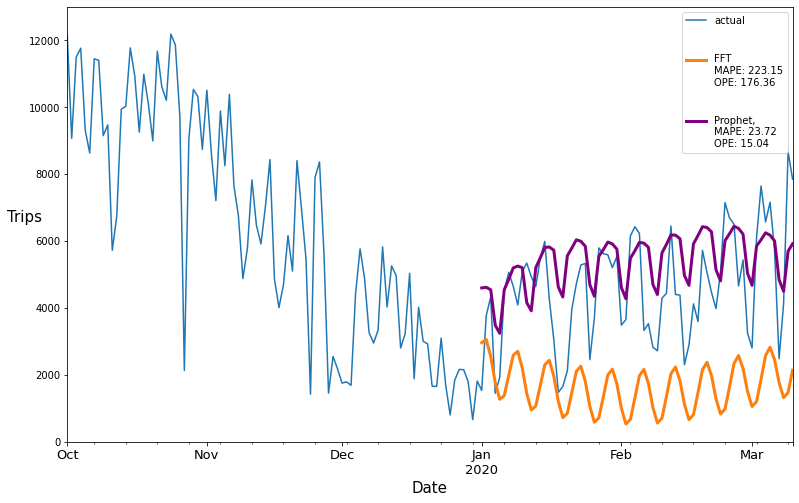

In [17]:
plt.figure(figsize=(13, 8))
series2.plot(label='actual')
prediction_FFT2.plot(label='\n\nFFT \nMAPE: '+str(round(mape(prediction_FFT2, series2),2))+'\nOPE: '+str(round(ope(prediction_FFT2, series2),2)),lw=3)
prediction_Prophet2.plot(label='\n\nProphet, \nMAPE: '+str(round(mape(prediction_Prophet2, series2),2))+'\nOPE: '+str(round(ope(prediction_Prophet2, series2),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2019-10-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-03-10', '%Y-%m-%d').date(),0,13000])
plt.ylabel('Trips',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend()
plt.show()

We see that for the time in 2020 before the state of emergency Prophet is far more accurate than FFT with respect to both metrics.

The additional forecasting value Prophet provides is that it didn't *underestimate* demand nearly to the extent FFT did. Relying on FFT to forecast demand pre-COVID could have caused Bluebikes to make operational decisions that could've led to significant lost business.

### Forecast 3<a name="fc3"></a>

For our third forecast we'll now feed our models all the daily demand data we have through June 23rd, so that we have the last week of June to test how well the models have been able to adapt to the major changes in the consumer behavior.

In [18]:
train3, val3 = series1.split_before(pd.Timestamp('20200623'))

In [19]:
model_FFT3 = FFT()
model_FFT3.fit(train3)
prediction_FFT3 = model_FFT3.predict(len(val3))

model_Prophet3 = Prophet(changepoints=['2020-03-23'],daily_seasonality=True)
model_Prophet3.fit(train3)
prediction_Prophet3 = model_Prophet3.predict(len(val3))

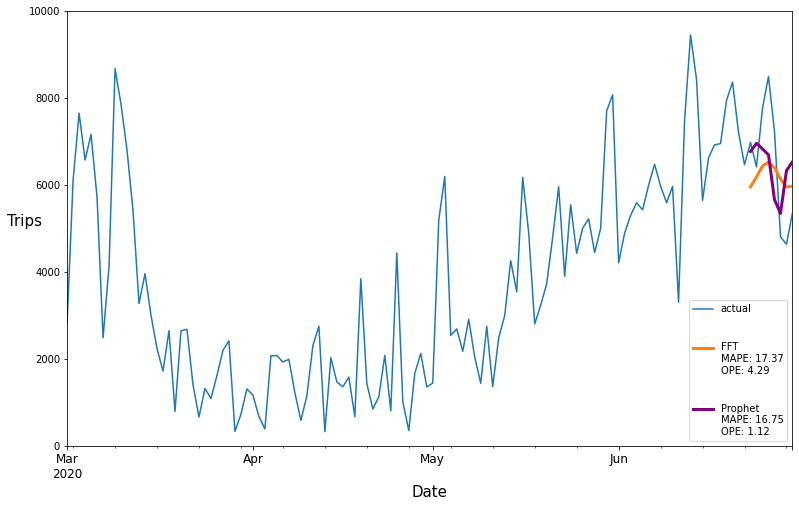

In [20]:
plt.figure(figsize=(13, 8))
series1.plot(label='actual')
prediction_FFT3.plot(label='\n\nFFT \nMAPE: '+str(round(mape(prediction_FFT3, series1),2))+'\nOPE: '+str(round(ope(prediction_FFT3, series1),2)),lw=3)
prediction_Prophet3.plot(label='\n\nProphet \nMAPE: '+str(round(mape(prediction_Prophet3, series1),2))+'\nOPE: '+str(round(ope(prediction_Prophet3, series1),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2020-03-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,10000])
plt.ylabel('Trips',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()

We see that both models predict the volume of demand for the last week of June relatively accurately, with Prophet predicting demand for the week to about 1% of the true value! One tweak I made to the Prophet model that dropped its OPE from around 13% to around 1% was to set the date of March 23rd 2020 as it's “changepoint”. That date was around the bottom of the rut that began around when the state of emergency was issued.

## Conclusions & Final Forecast<a name="Conclusions"></a>

While both models have relatively high performance with the post-state of emergency data, the superior performance of Prophet before and after the state of emergency was announced gives me more confidence that it will outperform FFT in the coming months and years.

This time series seems to clearly have a time when the underlying system was changed and it’s very interesting that Prophet's feature for detecting such situations was able to boost its performance so drastically.

The last forecast I’ll run will be for the first week in July, which I plan to test when the csv containing the July data is published in the coming weeks.

In [21]:
train4 = series1

In [22]:
model_FFT4 = FFT()
model_FFT4.fit(train4)
prediction_FFT4 = model_FFT4.predict(30)

model_Prophet4 = Prophet(changepoints=['2020-03-23'],daily_seasonality=True)
model_Prophet4.fit(train4)
prediction_Prophet4 = model_Prophet4.predict(30)

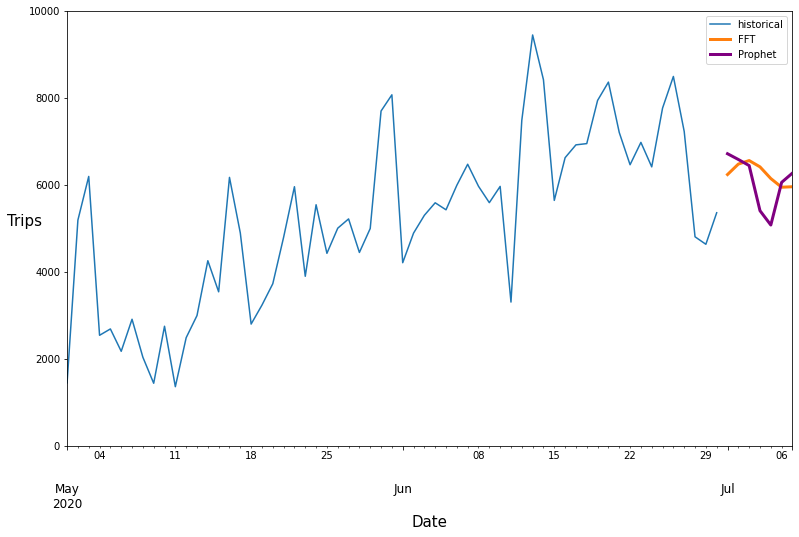

In [23]:
plt.figure(figsize=(13, 8))
series1.plot(label='historical')
prediction_FFT4.plot(label='FFT',lw=3)
prediction_Prophet4.plot(label='Prophet',lw=3,color='purple')
plt.axis([dt.datetime.strptime('2020-05-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-07-07', '%Y-%m-%d').date(),0,10000])
plt.ylabel('Trips',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()

Thanks for reading!! Please send any questions/commments/concerns to ian.klasky@gmail.com.

Stay safe!